In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import matplotlib.pyplot as plt

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=64)

# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                        transforms.ToTensor()
#                    ])),
#     batch_size=64)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 50828227.67it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 58294366.61it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 63494563.92it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14195625.01it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
class RBM(nn.Module):
   def __init__(self,
               n_vis,
               n_hin,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k

   def sample_from_p(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))

   def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h

   def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v

   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)

        h_ = h1
        for _ in range(self.k):
            pre_v_, v_ = self.h_to_v(h_)
            pre_h_, h_ = self.v_to_h(v_)

        return v,v_


In [4]:
# Initialize the Restricted Boltzmann Machine
n_vis = 784  # MNIST images are 28x28
n_hin = 500
rbm = RBM(n_vis, n_hin, k=1)

# Training hyperparameters
epochs = 5
learning_rate = 0.01
train_op = optim.SGD(rbm.parameters(),learning_rate)

# Training loop
for epoch in range(epochs):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()

        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print(f'Epoch {epoch} completed. Average Loss: {np.mean(loss_)}')

Epoch 0 completed. Average Loss: -19.237668991088867
Epoch 1 completed. Average Loss: -14.199090003967285
Epoch 2 completed. Average Loss: -14.107034683227539
Epoch 3 completed. Average Loss: -13.509485244750977
Epoch 4 completed. Average Loss: -13.065394401550293


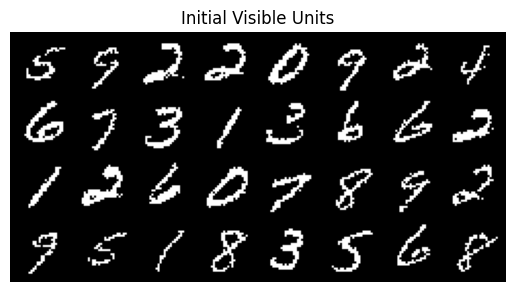

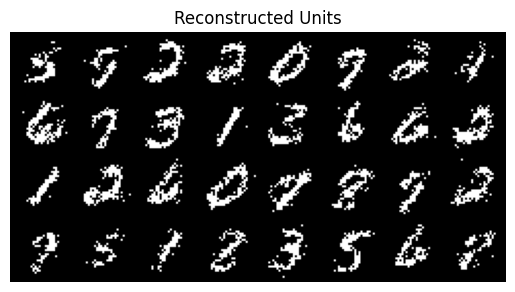

In [11]:
def show_and_save(file_name, img, title):
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    plt.imshow(npimg, cmap='gray')
    plt.title(title)
    plt.axis('off')
    f = f"./{file_name}.png"
    plt.imsave(f, npimg)
    plt.show()

show_and_save("initial_visible_units", make_grid(v.view(-1, 1, 28, 28).data), "Initial Visible Units")

show_and_save("reconstructed_visible_units", make_grid(v1.view(-1, 1, 28, 28).data), "Reconstructed Units")